# Datasets

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
from google.colab import files
# Upload API Token to access dataset from Kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yylife","key":"330509faec06f08d784a0a8752f54897"}'}

In [ ]:
# Download dataset from Kaggle
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle competitions download -c aptos2019-blindness-detection

-rw-r--r-- 1 root root 62 Jan  5 07:42 kaggle.json
/content
100% 9.51G/9.51G [04:42<00:00, 39.3MB/s]
100% 9.51G/9.51G [04:42<00:00, 36.2MB/s]


In [ ]:
# Unzip the dataset downloaded
!unzip aptos2019-blindness-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import torch
from torchvision import transforms, models, datasets
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torchvision.models import VGG16_Weights, ResNet50_Weights

## Data Preprocessing

In [ ]:
# Load train csv file and split into train and test set with ratio of 7:3
train = pd.read_csv('../content/train.csv')

train_set, test_set = train_test_split(train, test_size=0.3, random_state=42)

print('Number of train samples: ', train_set.shape[0])
print('Number of test samples: ', test_set.shape[0])

Number of train samples:  2563
Number of test samples:  1099


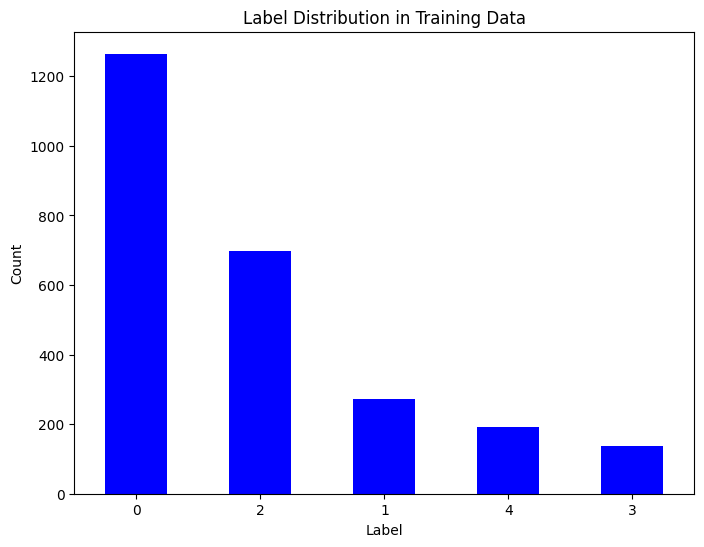

In [ ]:
# Check the distribution of the 'diagnosis' label in the training data
label_counts = train_set['diagnosis'].value_counts()

# Plot the distribution of train set before random sampling
plt.figure(figsize=(8,6))
label_counts.plot(kind='bar', color='blue')
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
class DataPreprocess(Dataset):

    # initialize
    def __init__(self, data, directory, transform = None, itype = '.png'):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.itype = itype

        # If 'diagnosis' exists, filter out rows with NaN values
        if 'diagnosis' in self.data.columns:
            self.data = self.data.dropna(subset=['diagnosis']).reset_index(drop=True)

    # length
    def __len__(self):
        return len(self.data)

    # get items
    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.data.iloc[idx]['id_code'] + self.itype)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (int(224), int(224)))
        image = torch.tensor(image)
        image = image.permute(2, 1, 0)
        image = self.transform(image)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'])

        if 'diagnosis' in self.data.columns:
            label = self.data.iloc[idx]['diagnosis']
            label = 0 if pd.isna(label) else label  # Replace NaN labels with 0
            label = torch.tensor(label, dtype=torch.long)
        else:
            label = torch.tensor(0, dtype=torch.long)  # Default label for test data

        return {'image': image, 'label': label}

In [ ]:
sample_size = 50

# Data Preprocess
train_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomRotation((-360, 360)),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomVerticalFlip(),
                                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                  transforms.RandomCrop(224),
                                  transforms.GaussianBlur(kernel_size=5),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 ])

test_trans = transforms.Compose([transforms.ToPILImage(),
                                  transforms.ToTensor(),
                                 ])

# Randomly select 50 samples from the test_set dataset
test_size = test_set.sample(n=sample_size, random_state=42).reset_index(drop=True)
test_sample = DataPreprocess(data = test_size, directory = '../content/train_images', transform = test_trans, itype ='.png' )

In [ ]:
# Random Oversampling the train set to ensure every classes contain same number of samples
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(train_set.drop('diagnosis', axis=1), train_set['diagnosis'])

# Update train dataset after random sampling
train_resampled = pd.concat([X_resampled, y_resampled], axis=1).reset_index(drop=True)

# Randomly select 50 samples from the train_resampled dataset
train_size = train_resampled.sample(n=sample_size, random_state=42).reset_index(drop=True)
train_sample_resampled = DataPreprocess(data = train_size, directory = '../content/train_images', transform = train_trans, itype ='.png' )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


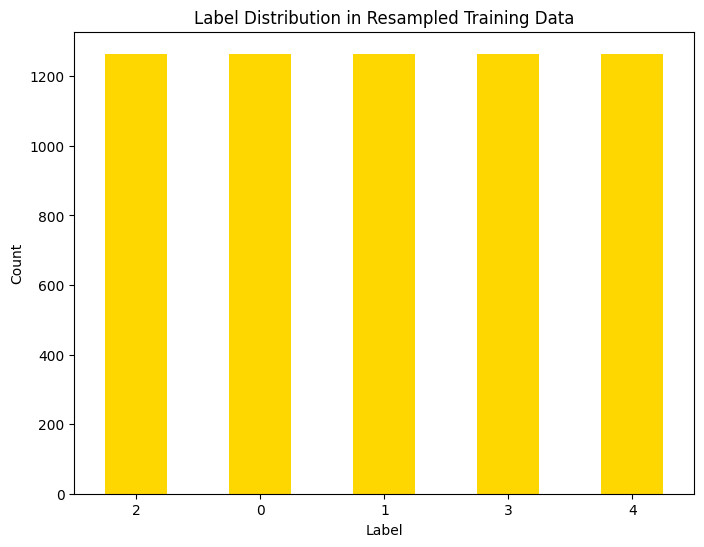

In [ ]:
# Check the distribution of the 'diagnosis' label in the training data
label_counts = train_resampled['diagnosis'].value_counts()

# Plot the distribution of train set after random sampling
plt.figure(figsize=(8,6))
label_counts.plot(kind='bar', color='gold')
plt.title('Label Distribution in Resampled Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Define hyperparameters
epochs = 20
batch_size = 32
learning_rate = 0.001
num_classes = 5
weight = 0.01

# Define DataLoader
train_loader = DataLoader(dataset=train_sample_resampled, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_sample, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## Method Definition

In [ ]:
# Method to train the model
def TrainModel(model, train_loader, optimizer, criterion, device):
    model.train()  # Set model to training mode
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in train_loader:
        images, labels = batch['image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the model parameters

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)  # Get the predicted labels

        all_preds.extend(preds.cpu().numpy())  # Store all predictions for F1 score
        all_labels.extend(labels.cpu().numpy())  # Store all labels for F1 score

    # Return the loss and accuracy for this epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)  # Weighted precision
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, precision, recall, f1, conf_matrix

In [ ]:
# Method to evaluate the model's performance
def TestModel(model, test_loader, criterion, device, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():  # Disable gradient computation for testing
        for batch in test_loader:
            images, labels = batch['image'].to(device), batch['label'].to(device)
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)  # Get probabilities for each class
            _, preds = torch.max(probs, 1)  # Get predicted class labels

            all_preds.extend(preds.cpu().numpy())  # Store predicted labels
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)  # Weighted precision
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return avg_loss, accuracy, precision, recall, f1, conf_matrix

In [ ]:
# Method to plot accuracy and loss curve
def plot_metrics(train_acc, test_acc, train_loss, test_loss, model_name):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_acc, label='Train Accuracy')
    plt.plot(range(epochs), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_loss, label='Train Loss')
    plt.plot(range(epochs), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Method to plot confusion matrix
def plot_confusion_matrix(conf_matrix, num_classes):
    fig, ax = plt.subplots(figsize = (6, 6))

    labels=['Class0', 'Class1', 'Class2', 'Class3', 'Class4']

    annot = conf_matrix.astype(int)
    sns.heatmap(conf_matrix, cmap='Blues', annot=annot, fmt='d', linewidths=0.5, ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    ax.set_aspect('equal')
    plt.show()

# EfficientNet-B0 Model

In [ ]:
from torchvision.models import EfficientNet_B0_Weights

# EfficientNetB0
efficientnet_b0 = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
efficientnet_b0.classifier[1] = nn.Sequential(
    nn.Linear(efficientnet_b0.classifier[1].in_features, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Add dropout for regularization
    nn.Linear(1024, num_classes)
)

# Unfreeze the classifier layers for fine-tuning
for param in efficientnet_b0.classifier[0].parameters():
    param.requires_grad = True

efficientnet_b0.to(device)

optimizer_b0 = optim.Adam(efficientnet_b0.parameters(), lr=learning_rate, weight_decay=weight)
criterion_b0 = nn.CrossEntropyLoss()

train_loss_b0, train_acc_b0, test_loss_b0, test_acc_b0, f1_b0, test_f1_b0, conf_matrix_b0 = [], [], [], [], [], [], []
test_precision_b0, test_recall_b0, test_conf_matrix_b0 = [], [], []
best_f1_b0, best_test_f1_b0 = 0, 0
best_conf_matrix_b0, best_test_conf_matrix_b0 = None, None

# Train EfficientNetB0
for epoch in range(epochs):
    # Training
    train_loss_epoch_b0, train_acc_epoch_b0, precision_epoch_b0, recall_epoch_b0, f1_epoch_b0, conf_matrix = TrainModel(efficientnet_b0, train_loader, optimizer_b0, criterion_b0, device)
    train_loss_b0.append(train_loss_epoch_b0)
    train_acc_b0.append(train_acc_epoch_b0)
    f1_b0.append(f1_epoch_b0)
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Acc: {train_acc_b0[-1]:.4f}, Train Loss: {train_loss_b0[-1]:.4f}, F1: {f1_b0[-1]:.4f}")

    # Validation
    test_loss_epoch_b0, test_acc_epoch_b0, test_precision_epoch_b0, test_recall_epoch_b0, test_f1_epoch_b0, test_conf_matrix = TestModel(efficientnet_b0, test_loader, criterion_b0, device)
    test_loss_b0.append(test_loss_epoch_b0)
    test_acc_b0.append(test_acc_epoch_b0)
    test_f1_b0.append(test_f1_epoch_b0)
    print(f"Test Acc: {test_acc_b0[-1]:.4f}, Test Loss: {test_loss_b0[-1]:.4f}, F1: {test_f1_b0[-1]:.4f}")

    # Track best F1 score and confusion matrix for Training Set
    if f1_epoch_b0 > best_f1_b0:
        best_f1_b0 = f1_epoch_b0
        best_conf_matrix_b0 = conf_matrix
        recall_b0 = recall_epoch_b0
        precision_b0 = precision_epoch_b0

    # Track best F1 score and confusion matrix for Validation Set
    if test_f1_epoch_b0 > best_test_f1_b0:
        best_test_f1_b0 = test_f1_epoch_b0
        best_test_conf_matrix_b0 = conf_matrix
        test_recall_b0 = recall_epoch_b0
        test_precision_b0 = precision_epoch_b0

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


Epoch 1/20
Train Acc: 0.1400, Train Loss: 1.6792, F1: 0.1331
Test Acc: 0.1800, Test Loss: 1.5899, F1: 0.1321
Epoch 2/20
Train Acc: 0.2400, Train Loss: 1.5350, F1: 0.1636
Test Acc: 0.2400, Test Loss: 1.5519, F1: 0.1899
Epoch 3/20
Train Acc: 0.3200, Train Loss: 1.5080, F1: 0.3125
Test Acc: 0.4000, Test Loss: 1.4409, F1: 0.2533
Epoch 4/20
Train Acc: 0.5400, Train Loss: 1.3827, F1: 0.5314
Test Acc: 0.3800, Test Loss: 1.3595, F1: 0.2124
Epoch 5/20
Train Acc: 0.5600, Train Loss: 1.2472, F1: 0.5567
Test Acc: 0.3800, Test Loss: 1.2987, F1: 0.2188
Epoch 6/20
Train Acc: 0.5200, Train Loss: 1.1963, F1: 0.4920
Test Acc: 0.4000, Test Loss: 1.2504, F1: 0.2406
Epoch 7/20
Train Acc: 0.5200, Train Loss: 1.1154, F1: 0.4821
Test Acc: 0.4600, Test Loss: 1.2302, F1: 0.3336
Epoch 8/20
Train Acc: 0.5800, Train Loss: 1.2469, F1: 0.5736
Test Acc: 0.4400, Test Loss: 1.2335, F1: 0.3001
Epoch 9/20
Train Acc: 0.6200, Train Loss: 0.9392, F1: 0.5988
Test Acc: 0.4800, Test Loss: 1.2481, F1: 0.3765
Epoch 10/20
Train A

## Model Performance

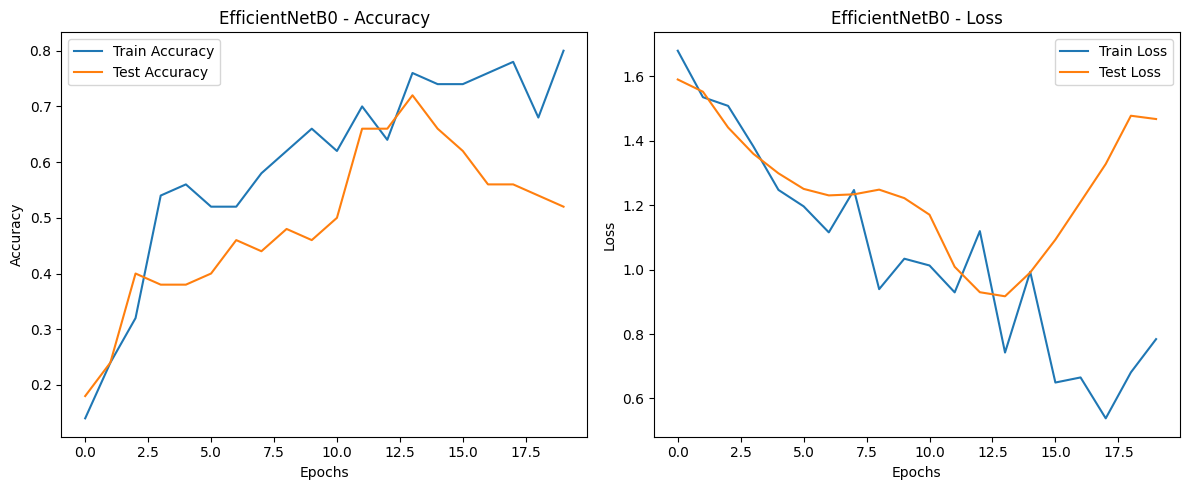

Best Train Accuracy: 0.8000
Best Test Accuracy: 0.7200


In [ ]:
# Accuracy and Loss Curve
plot_metrics(train_acc_b0, test_acc_b0, train_loss_b0, test_loss_b0, "EfficientNetB0")
best_train_acc = max(train_acc_b0)
best_test_acc = max(test_acc_b0)
print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

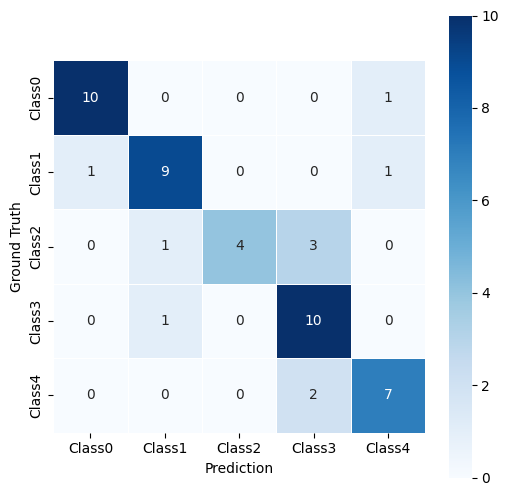

EfficientNet-B0
F1 score: 0.7958974358974359
Precision: 0.8266666666666667
Recall: 0.8


In [ ]:
plot_confusion_matrix(best_conf_matrix_b0, 5)
print("EfficientNet-B0")
print("F1 score: " + str(best_f1_b0))
print("Precision: " + str(precision_b0))
print("Recall: " + str(recall_b0))

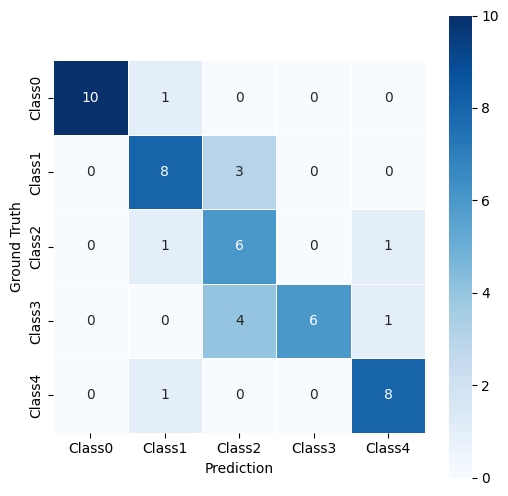

EfficientNet-B0
F1 score: 0.693025641025641
Precision: 0.8178461538461539
Recall: 0.76


In [ ]:
plot_confusion_matrix(best_test_conf_matrix_b0, 5)
print("EfficientNet-B0")
print("F1 score: " + str(best_test_f1_b0))
print("Precision: " + str(test_precision_b0))
print("Recall: " + str(test_recall_b0))

In [ ]:
# Print EfficientNetB0 structure
print("EfficientNet-B0 Model Structure:")
print(efficientnet_b0)
print("\nSummary:")
summary(efficientnet_b0, input_size=(3, 224, 224))  # Replace (3, 224, 224) with your input shape

EfficientNet-B0 Model Structure:
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )

# VGG-16 Model

In [ ]:
# VGG16
# load model
vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT)

# Replace the final layer in the classifier with a customized sequential block
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(vgg16.classifier[6].in_features, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, num_classes)
)

for param in vgg16.classifier[6].parameters():
    param.requires_grad = True
vgg16.to(device)

optimizer_vgg = optim.Adam(vgg16.parameters(), lr=learning_rate, weight_decay=weight)
criterion_vgg = nn.CrossEntropyLoss()

train_loss_vgg, train_acc_vgg, test_loss_vgg, test_acc_vgg, f1_vgg, test_f1_vgg, conf_matrix_vgg = [], [], [], [], [], [], []
test_precision_vgg, test_recall_vgg, test_conf_matrix_vgg = [], [], []
best_f1_vgg, best_test_f1_vgg = 0, 0
best_conf_matrix_vgg, best_test_conf_matrix_b0 = None, None

for epoch in range(epochs):
    # Training
    train_loss_epoch_vgg, train_acc_epoch_vgg, precision_epoch_vgg, recall_epoch_vgg, f1_epoch_vgg, conf_matrix = TrainModel(vgg16, train_loader, optimizer_vgg, criterion_vgg, device)
    train_loss_vgg.append(train_loss_epoch_vgg)
    train_acc_vgg.append(train_acc_epoch_vgg)
    f1_vgg.append(f1_epoch_vgg)
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Acc: {train_acc_vgg[-1]:.4f}, Train Loss: {train_loss_vgg[-1]:.4f}, F1: {f1_vgg[-1]:.4f}")


    # Testing
    test_loss_epoch_vgg, test_acc_epoch_vgg, test_precision_epoch_vgg, test_recall_epoch_vgg, test_f1_epoch_vgg, test_conf_matrix = TestModel(vgg16, test_loader, criterion_vgg, device)
    test_loss_vgg.append(test_loss_epoch_vgg)
    test_acc_vgg.append(test_acc_epoch_vgg)
    test_f1_vgg.append(test_f1_epoch_vgg)
    print(f"Test Acc: {test_acc_vgg[-1]:.4f}, Test Loss: {test_loss_vgg[-1]:.4f}, F1: {test_f1_vgg[-1]:.4f}")


    # Track best F1 score and confusion matrix - Training
    if f1_epoch_vgg > best_f1_vgg:
        best_f1_vgg = f1_epoch_vgg
        best_conf_matrix_vgg = conf_matrix
        recall_vgg = recall_epoch_vgg
        precision_vgg = precision_epoch_vgg

    # Track best F1 score and confusion matrix for Testing Set
    if test_f1_epoch_vgg > best_test_f1_vgg:
        best_test_f1_vgg = test_f1_epoch_vgg
        best_test_conf_matrix_vgg = conf_matrix
        test_recall_vgg = recall_epoch_vgg
        test_precision_vgg = precision_epoch_vgg

Epoch 1/20
Train Acc: 0.1600, Train Loss: 2.3107, F1: 0.1604
Test Acc: 0.3800, Test Loss: 1.5972, F1: 0.2093
Test Acc: 0.3800, Test Loss: 1.6060, F1: 0.2093
Epoch 3/20
Train Acc: 0.2000, Train Loss: 1.6103, F1: 0.1101
Test Acc: 0.3800, Test Loss: 1.6363, F1: 0.2093
Epoch 4/20
Train Acc: 0.1800, Train Loss: 1.6588, F1: 0.1618
Test Acc: 0.0400, Test Loss: 1.6470, F1: 0.0031
Epoch 5/20
Train Acc: 0.2000, Train Loss: 1.7011, F1: 0.1251
Test Acc: 0.1800, Test Loss: 1.6145, F1: 0.0549
Epoch 6/20
Train Acc: 0.2200, Train Loss: 1.6326, F1: 0.0793
Test Acc: 0.1800, Test Loss: 1.6170, F1: 0.0549
Epoch 7/20
Train Acc: 0.2200, Train Loss: 1.6012, F1: 0.0793
Test Acc: 0.3800, Test Loss: 1.6009, F1: 0.2093
Epoch 8/20
Train Acc: 0.2400, Train Loss: 1.6197, F1: 0.1899
Test Acc: 0.3800, Test Loss: 1.5890, F1: 0.2093
Epoch 9/20
Train Acc: 0.2400, Train Loss: 1.6256, F1: 0.1335
Test Acc: 0.1800, Test Loss: 1.6370, F1: 0.0549
Epoch 10/20
Train Acc: 0.1600, Train Loss: 1.6336, F1: 0.1264
Test Acc: 0.0400, 

## Model Performance

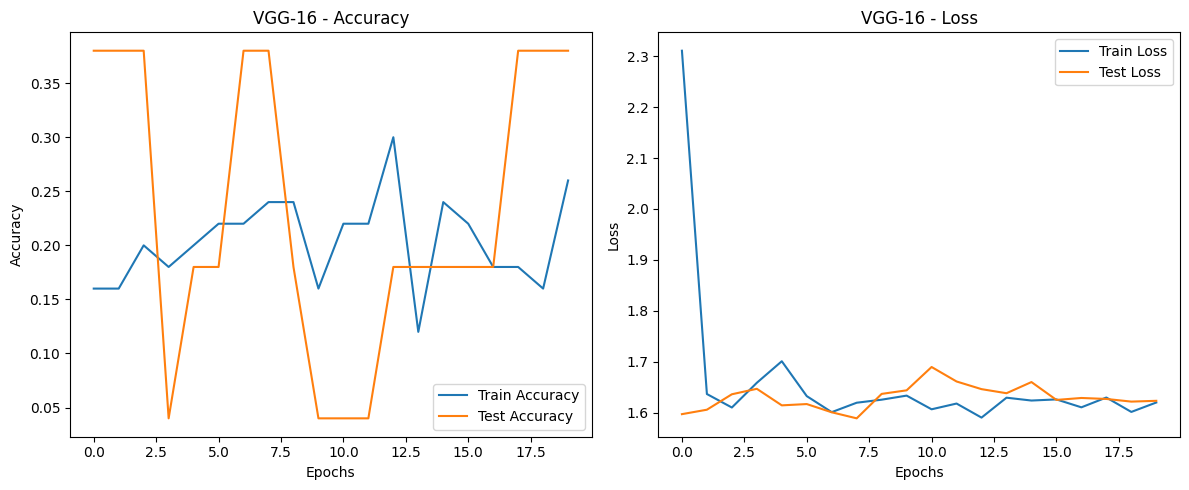

Best Train Accuracy: 0.3000
Best Test Accuracy: 0.3800


In [ ]:
# Accuracy and Loss Curve
plot_metrics(train_acc_vgg, test_acc_vgg, train_loss_vgg, test_loss_vgg, "VGG-16")
best_train_acc = max(train_acc_vgg)
best_test_acc = max(test_acc_vgg)
print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")


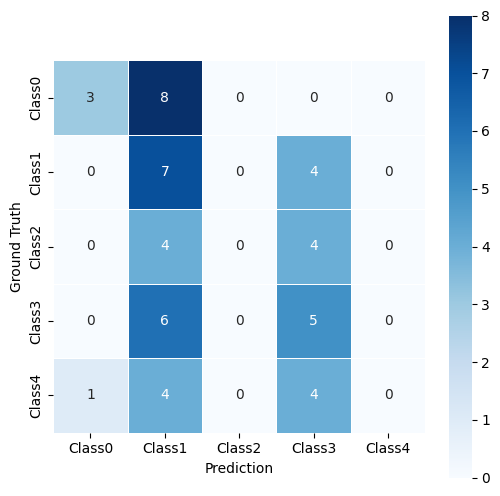

VGG-16
F1 score: 0.24357142857142858
Precision: 0.2828093306288032
Recall: 0.3


In [ ]:
# Training
plot_confusion_matrix(best_conf_matrix_vgg, 5)
print("VGG-16")
print("F1 score: " + str(best_f1_vgg))
print("Precision: " + str(precision_vgg))
print("Recall: " + str(recall_vgg))

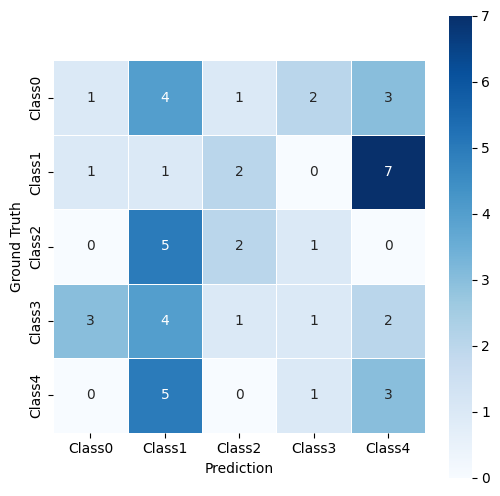

VGG-16
F1 score: 0.20927536231884059
Precision: 0.1889122807017544
Recall: 0.16


In [ ]:
# Testing
plot_confusion_matrix(best_test_conf_matrix_vgg, 5)
print("VGG-16")
print("F1 score: " + str(best_test_f1_vgg))
print("Precision: " + str(test_precision_vgg))
print("Recall: " + str(test_recall_vgg))

In [ ]:
# Print VGG-16 structure
print("\nVGG-16 Model Structure:")
print(vgg16)
print("\nSummary:")
summary(vgg16, input_size=(3, 224, 224))  # Replace (3, 224, 224) with your input shape


VGG-16 Model Structure:
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride

# ResNet-50 Model

In [ ]:
# ResNet-50
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, num_classes)
)

# Unfreeze the fully connected layer for fine-tuning
for param in resnet50.fc.parameters():
    param.requires_grad = True
resnet50.to(device)

optimizer_rn = optim.Adam(resnet50.parameters(), lr=learning_rate, weight_decay=weight)
criterion_rn = nn.CrossEntropyLoss()

train_loss_rn, train_acc_rn, test_loss_rn, test_acc_rn, f1_rn, test_f1_rn, conf_matrix_rn = [], [], [], [], [], [], []
test_precision_rn, test_recall_rn, test_conf_matrix_rn = [], [], []
best_f1_rn, best_test_f1_rn = 0, 0
best_conf_matrix_rn, best_test_conf_matrix_rn = None, None

for epoch in range(epochs):
    # Training
    train_loss_epoch_rn, train_acc_epoch_rn, precision_epoch_rn, recall_epoch_rn, f1_epoch_rn, conf_matrix = TrainModel(resnet50, train_loader, optimizer_rn, criterion_rn, device)
    train_loss_rn.append(train_loss_epoch_rn)
    train_acc_rn.append(train_acc_epoch_rn)
    f1_rn.append(f1_epoch_rn)
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Acc: {train_acc_rn[-1]:.4f}, Train Loss: {train_loss_rn[-1]:.4f}, F1: {f1_rn[-1]:.4f}")

    # Testing
    test_loss_epoch_rn, test_acc_epoch_rn, test_precision_epoch_rn, test_recall_epoch_rn, test_f1_epoch_rn, test_conf_matrix = TestModel(resnet50, test_loader, criterion_rn, device)
    test_loss_rn.append(test_loss_epoch_rn)
    test_acc_rn.append(test_acc_epoch_rn)
    test_f1_rn.append(test_f1_epoch_rn)
    print(f"Test Acc: {test_acc_rn[-1]:.4f}, Test Loss: {test_loss_rn[-1]:.4f}, F1: {test_f1_rn[-1]:.4f}")

    # Track best F1 score and confusion matrix - Training
    if f1_epoch_rn > best_f1_rn:
        best_f1_rn = f1_epoch_rn
        best_conf_matrix_rn = conf_matrix
        recall_rn = recall_epoch_rn
        precision_rn = precision_epoch_rn

    # Track best F1 score and confusion matrix for Testing Set
    if test_f1_epoch_rn > best_test_f1_rn:
        best_test_f1_rn = test_f1_epoch_rn
        best_test_conf_matrix_rn = test_conf_matrix
        test_recall_rn = test_recall_epoch_rn
        test_precision_rn = test_precision_epoch_rn

Epoch 1/20
Train Acc: 0.1800, Train Loss: 1.6393, F1: 0.1690
Test Acc: 0.3200, Test Loss: 1.6100, F1: 0.3319
Epoch 2/20
Train Acc: 0.2800, Train Loss: 1.5884, F1: 0.2488
Test Acc: 0.3600, Test Loss: 1.5498, F1: 0.3202
Epoch 3/20
Train Acc: 0.2600, Train Loss: 1.5469, F1: 0.1764
Test Acc: 0.4000, Test Loss: 1.3865, F1: 0.2533
Epoch 4/20
Train Acc: 0.3800, Train Loss: 1.4959, F1: 0.3067
Test Acc: 0.4000, Test Loss: 1.3894, F1: 0.2595
Epoch 5/20
Train Acc: 0.4000, Train Loss: 1.3052, F1: 0.3417
Test Acc: 0.3800, Test Loss: 1.8470, F1: 0.2292
Epoch 6/20
Train Acc: 0.4800, Train Loss: 1.2490, F1: 0.3903
Test Acc: 0.1600, Test Loss: 3.8509, F1: 0.1290
Epoch 7/20
Train Acc: 0.5400, Train Loss: 1.3121, F1: 0.4960
Test Acc: 0.3800, Test Loss: 3.9183, F1: 0.2124
Epoch 8/20
Train Acc: 0.4200, Train Loss: 1.3491, F1: 0.3806
Test Acc: 0.4000, Test Loss: 1.8663, F1: 0.2348
Epoch 9/20
Train Acc: 0.4000, Train Loss: 1.3645, F1: 0.3667
Test Acc: 0.4600, Test Loss: 1.2421, F1: 0.3409
Epoch 10/20
Train A

## Model Performance

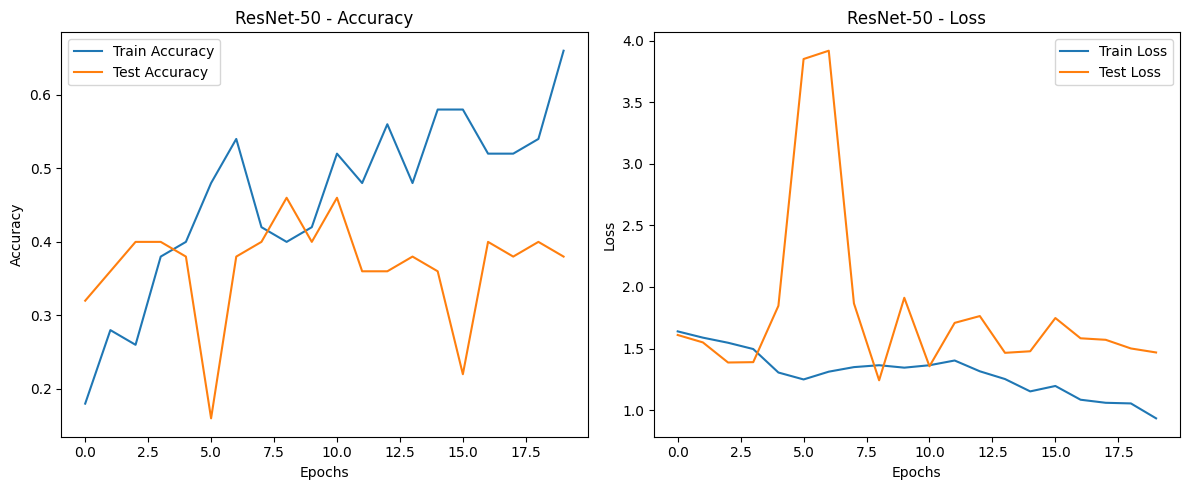

Best Train Accuracy: 0.6600
Best Test Accuracy: 0.4600


In [ ]:
# Accuracy and Loss Curve
plot_metrics(train_acc_rn, test_acc_rn, train_loss_rn, test_loss_rn, "ResNet-50")
best_train_acc = max(train_acc_rn)
best_test_acc = max(test_acc_rn)
print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

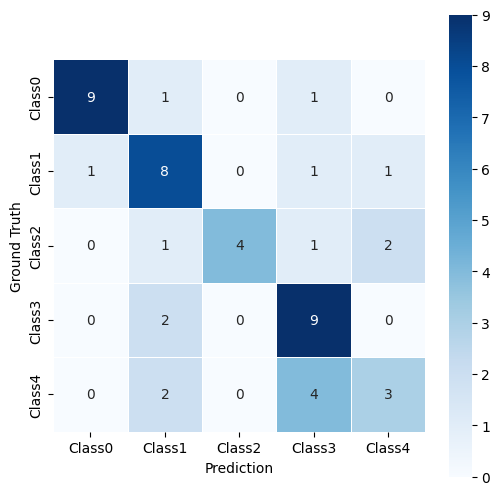

ResNet-50
F1 score: 0.6547047619047619
Precision: 0.6974642857142856
Recall: 0.66


In [ ]:
# Training
plot_confusion_matrix(best_conf_matrix_rn, 5)
print("ResNet-50")
print("F1 score: " + str(best_f1_rn))
print("Precision: " + str(precision_rn))
print("Recall: " + str(recall_rn))

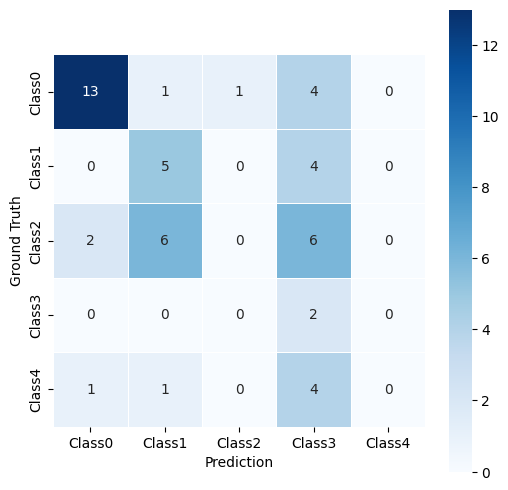

ResNet-50
F1 score: 0.37137662337662336
Precision: 0.3819807692307692
Recall: 0.4


In [ ]:
# Testing
plot_confusion_matrix(best_test_conf_matrix_rn, 5)
print("ResNet-50")
print("F1 score: " + str(best_test_f1_rn))
print("Precision: " + str(test_precision_rn))
print("Recall: " + str(test_recall_rn))

In [ ]:
# Print ResNet-50 structure
print("\nResNet-50 Model Structure:")
print(resnet50)
print("\nSummary:")
summary(resnet50, input_size=(3, 224, 224))  # Replace (3, 224, 224) with your input shape


ResNet-50 Model Structure:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ker

# Simple CNN Model

In [ ]:
# SimpleCNN
simple_cnn = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 56 * 56, num_classes)  # Correct flattened size
)
simple_cnn.to(device)

optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=learning_rate, weight_decay=weight)
criterion_cnn = nn.CrossEntropyLoss()

train_loss_cnn, train_acc_cnn, test_loss_cnn, test_acc_cnn, f1_cnn, test_f1_cnn, conf_matrix_cnn = [], [], [], [], [], [], []
best_f1_cnn, best_test_f1_cnn = 0, 0
best_conf_matrix_cnn, best_test_conf_matrix_cnn = None, None

for epoch in range(epochs):
    # Training
    train_loss_epoch_cnn, train_acc_epoch_cnn, precision_epoch_cnn, recall_epoch_cnn, f1_epoch_cnn, conf_matrix = TrainModel(simple_cnn, train_loader, optimizer_cnn, criterion_cnn, device)
    train_loss_cnn.append(train_loss_epoch_cnn)
    train_acc_cnn.append(train_acc_epoch_cnn)
    f1_cnn.append(f1_epoch_cnn)
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Acc: {train_acc_cnn[-1]:.4f}, Train Loss: {train_loss_cnn[-1]:.4f}, F1: {f1_cnn[-1]:.4f}")

    # Testing
    test_loss_epoch_cnn, test_acc_epoch_cnn, test_precision_epoch_cnn, test_recall_epoch_cnn, test_f1_epoch_cnn, test_conf_matrix = TestModel(simple_cnn, test_loader, criterion_cnn, device)
    test_loss_cnn.append(test_loss_epoch_cnn)
    test_acc_cnn.append(test_acc_epoch_cnn)
    test_f1_cnn.append(test_f1_epoch_cnn)
    print(f"Test Acc: {test_acc_cnn[-1]:.4f}, Test Loss: {test_loss_cnn[-1]:.4f}, F1: {test_f1_cnn[-1]:.4f}")


    # Track best F1 score and confusion matrix - Training
    if f1_epoch_cnn > best_f1_cnn:
        best_f1_cnn = f1_epoch_cnn
        best_conf_matrix_cnn = conf_matrix
        recall_cnn = recall_epoch_cnn
        precision_cnn = precision_epoch_cnn

    # Track best F1 score and confusion matrix for Testing Set
    if test_f1_epoch_cnn > best_test_f1_cnn:
        best_test_f1_cnn = test_f1_epoch_cnn
        best_test_conf_matrix_cnn = conf_matrix
        test_recall_cnn = recall_epoch_cnn
        test_precision_cnn = precision_epoch_cnn

Epoch 1/20
Train Acc: 0.0800, Train Loss: 19.6807
Test Acc: 0.1200, Test Loss: 2.1854, F1: 0.0257
Epoch 2/20
Train Acc: 0.1800, Train Loss: 16.3114
Test Acc: 0.2200, Test Loss: 3.2162, F1: 0.1367
Epoch 3/20
Train Acc: 0.2000, Train Loss: 9.6361
Test Acc: 0.2600, Test Loss: 4.4702, F1: 0.1568
Epoch 4/20
Train Acc: 0.2400, Train Loss: 9.5620
Test Acc: 0.2800, Test Loss: 4.1978, F1: 0.1225
Epoch 5/20
Train Acc: 0.1800, Train Loss: 5.8976
Test Acc: 0.3600, Test Loss: 3.2772, F1: 0.2296
Epoch 6/20
Train Acc: 0.2600, Train Loss: 2.9664
Test Acc: 0.2800, Test Loss: 2.6840, F1: 0.2075
Epoch 7/20
Train Acc: 0.2200, Train Loss: 2.0387
Test Acc: 0.2400, Test Loss: 2.5889, F1: 0.1812
Epoch 8/20
Train Acc: 0.2600, Train Loss: 1.7757
Test Acc: 0.3000, Test Loss: 2.8429, F1: 0.1839
Epoch 9/20
Train Acc: 0.3000, Train Loss: 1.5378
Test Acc: 0.3600, Test Loss: 3.2273, F1: 0.2012
Epoch 10/20
Train Acc: 0.2400, Train Loss: 1.5032
Test Acc: 0.3600, Test Loss: 3.6526, F1: 0.2012
Epoch 11/20
Train Acc: 0.22

## Model Performance

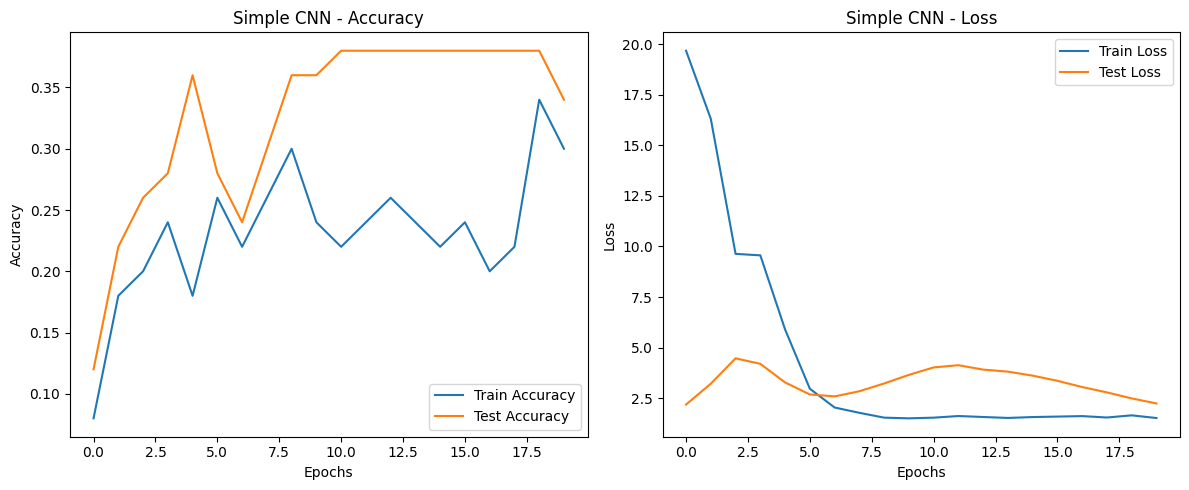

Best Train Accuracy: 0.3400
Best Test Accuracy: 0.3800


In [ ]:
# Accuracy and Loss Curve
plot_metrics(train_acc_cnn, test_acc_cnn, train_loss_cnn, test_loss_cnn, "Simple CNN")
best_train_acc = max(train_acc_cnn)
best_test_acc = max(test_acc_cnn)
print(f"Best Train Accuracy: {best_train_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

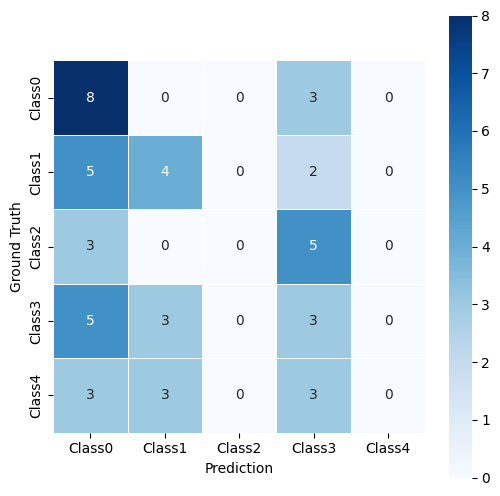

Simple CNN
F1 score: 0.23326984126984127
Precision: 0.20258333333333334
Recall: 0.3


In [ ]:
# Training
plot_confusion_matrix(best_conf_matrix_cnn, 5)
print("Simple CNN")
print("F1 score: " + str(best_f1_cnn))
print("Precision: " + str(precision_cnn))
print("Recall: " + str(recall_cnn))

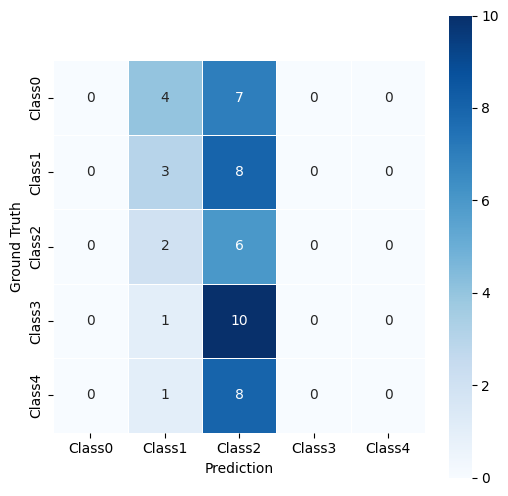

Simple CNN
F1 score: 0.22955165692007795
Precision: 0.08461538461538462
Recall: 0.18


In [ ]:
# Testing
plot_confusion_matrix(best_test_conf_matrix_cnn, 5)
print("Simple CNN")
print("F1 score: " + str(best_test_f1_cnn))
print("Precision: " + str(test_precision_cnn))
print("Recall: " + str(test_recall_cnn))

# Models' Performance in Graph Bar

## Training Performance

In [ ]:
print("EfficientNetB0")
print("F1 score: " + str(best_f1_b0))
print("Precision: " + str(precision_b0))
print("Recall: " + str(recall_b0))
print("\n")
print("VGG-16")
print("F1 score: " + str(best_f1_vgg))
print("Precision: " + str(precision_vgg))
print("Recall: " + str(recall_vgg))
print("\n")
print("ResNet-50")
print("F1 score: " + str(best_f1_rn))
print("Precision: " + str(precision_rn))
print("Recall: " + str(recall_rn))
print("\n")
print("Simple CNN")
print("F1 score: " + str(best_f1_cnn))
print("Precision: " + str(precision_cnn))
print("Recall: " + str(recall_cnn))

EfficientNetB0
F1 score: 0.7958974358974359
Precision: 0.8266666666666667
Recall: 0.8


VGG-16
F1 score: 0.24357142857142858
Precision: 0.2828093306288032
Recall: 0.3


ResNet-50
F1 score: 0.6547047619047619
Precision: 0.6974642857142856
Recall: 0.66


Simple CNN
F1 score: 0.23326984126984127
Precision: 0.20258333333333334
Recall: 0.3


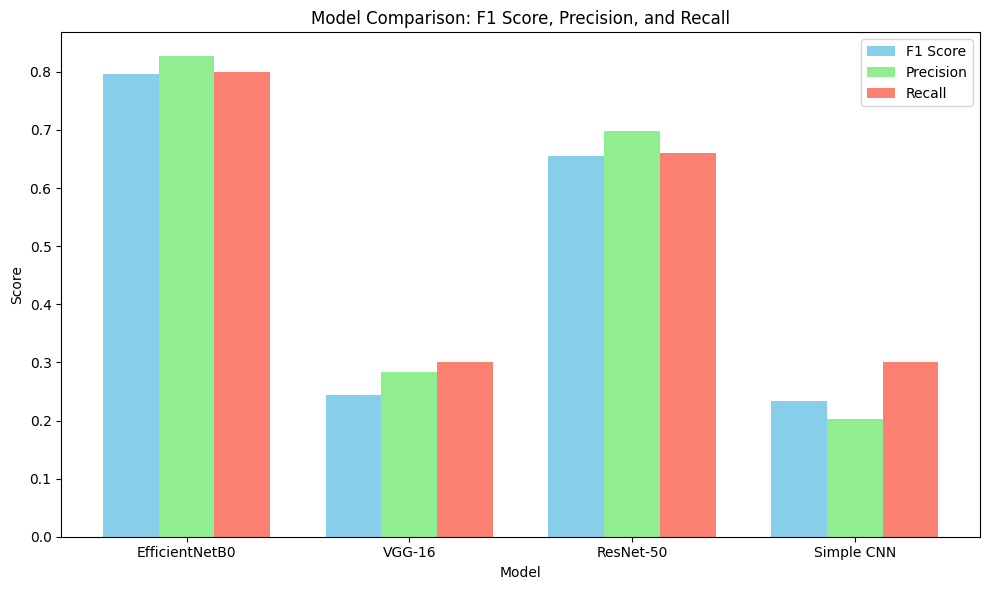

In [ ]:
# Data for the models and their metrics
models = ['EfficientNetB0', 'VGG-16', 'ResNet-50', 'Simple CNN']
f1_scores = [best_f1_b0, best_f1_vgg, best_f1_rn, best_f1_cnn]
precisions = [precision_b0, precision_vgg, precision_rn, precision_cnn]
recalls = [recall_b0, recall_vgg, recall_rn, recall_cnn]

# Set up the x-axis positions for the bars
x = np.arange(len(models))

# Set up the figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width for grouping
width = 0.25

# Create the bars for F1 score, Precision, and Recall
bar1 = ax.bar(x - width, f1_scores, width, label='F1 Score', color='skyblue')
bar2 = ax.bar(x, precisions, width, label='Precision', color='lightgreen')
bar3 = ax.bar(x + width, recalls, width, label='Recall', color='salmon')

# Adding labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: F1 Score, Precision, and Recall')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Testing Performance

In [ ]:
print("EfficientNetB0")
print("F1 score: " + str(best_test_f1_b0))
print("Precision: " + str(test_precision_b0))
print("Recall: " + str(test_recall_b0))
print("\n")
print("VGG-16")
print("F1 score: " + str(best_test_f1_vgg))
print("Precision: " + str(test_precision_vgg))
print("Recall: " + str(test_recall_vgg))
print("\n")
print("ResNet-50")
print("F1 score: " + str(best_test_f1_rn))
print("Precision: " + str(test_precision_rn))
print("Recall: " + str(test_recall_rn))
print("\n")
print("Simple CNN")
print("F1 score: " + str(best_test_f1_cnn))
print("Precision: " + str(test_precision_cnn))
print("Recall: " + str(test_recall_cnn))

EfficientNetB0
F1 score: 0.693025641025641
Precision: 0.8178461538461539
Recall: 0.76


VGG-16
F1 score: 0.20927536231884059
Precision: 0.1889122807017544
Recall: 0.16


ResNet-50
F1 score: 0.37137662337662336
Precision: 0.3819807692307692
Recall: 0.4


Simple CNN
F1 score: 0.22955165692007795
Precision: 0.08461538461538462
Recall: 0.18


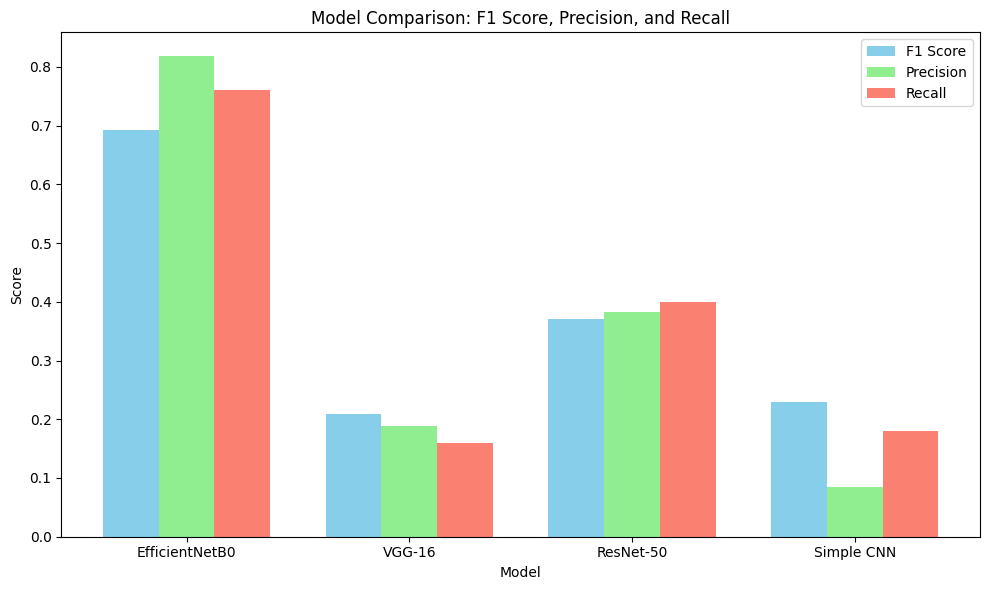

In [ ]:
# Data for the models and their metrics
models = ['EfficientNetB0', 'VGG-16', 'ResNet-50', 'Simple CNN']
f1_scores = [best_test_f1_b0, best_test_f1_vgg, best_test_f1_rn, best_test_f1_cnn]
precisions = [test_precision_b0, test_precision_vgg, test_precision_rn, test_precision_cnn]
recalls = [test_recall_b0, test_recall_vgg, test_recall_rn, test_recall_cnn]

# Set up the x-axis positions for the bars
x = np.arange(len(models))

# Set up the figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width for grouping
width = 0.25

# Create the bars for F1 score, Precision, and Recall
bar1 = ax.bar(x - width, f1_scores, width, label='F1 Score', color='skyblue')
bar2 = ax.bar(x, precisions, width, label='Precision', color='lightgreen')
bar3 = ax.bar(x + width, recalls, width, label='Recall', color='salmon')

# Adding labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Comparison: F1 Score, Precision, and Recall')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()